Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
      <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/FunctionGemma/%5BFunctionGemma%5DFinetune_FunctionGemma_270M_for_Mobile_Actions_with_Hugging_Face.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Fine-tune FunctionGemma 270M for Mobile Actions

This notebook fine-tunes FunctionGemma for the task of taking user request to perform mobile actions through the Hugging Face Transformer Reinforcement Learning ([TRL](https://huggingface.co/docs/trl/en/index)) library.

When training [FunctionGemma 270M](https://huggingface.co/google/functiongemma-270m-it) on a Google Colab A100 GPU accelerator, this process can take 60 minutes end-to-end. Run each code snippet to:

1. Set up the Colab environment
2. Prepare a dataset for fine-tuning
3. Load and test the base FunctionGemma 270M model
4. Fine-tune the model
5. Test, evaluate, and save the model for further use
6. Convert the checkpoint to `.litertlm` for deployment

## Prerequisites

This colab needs the **A100 GPU**. You will need a Colab Pro subscription or Colab Pay to Go with credits.

## Set up development environment

The first step is to install the necessary libraries using the `pip` package installer.

In [2]:
%pip install torch
%pip install -U transformers==4.57.1 trl==0.25.1 datasets==4.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


**You may have to restart your session (runtime) to use newly installed libraries.**

##Enable Hugging Face permissions

To use Gemma models, you'll need to accept the model usage license and create an Access Token:

1. **Accept license** on the [model page](http://huggingface.co/google/functiongemma-270m-it).

2. **Get a valid [Access Token](https://huggingface.co/settings/tokens) with 'Write' access (very important!)**

3. **Create a new Colab secret** in the left toolbar. Specify `HF_TOKEN` as the 'Name', add your unique token as the 'Value', and toggle 'Notebook access' on.

In [3]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

## Load the model

You can access [FunctionGemma 270M](https://huggingface.co/google/functiongemma-270m-it) from Hugging Face Hub by accepting the license terms. The instruction-tuned version of the model has already been trained on how to follow directions and with fine-tuning, you'll now adapt it to a new task.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

gemma_model = "google/functiongemma-270m-it"
base_model = AutoModelForCausalLM.from_pretrained(
    gemma_model,
    device_map="auto",
    attn_implementation="eager",
    dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

print(f"Device: {base_model.device}")
print(f"DType:  {base_model.dtype}")

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Device: cuda:0
DType:  torch.bfloat16


Device should print as `cuda` if you're using a GPU runtime.

## Load the dataset

To fine-tune FunctionGemma, we utilize the [Mobile Actions
dataset](https://huggingface.co/datasets/google/mobile-actions), which is
publicly available on Hugging Face. Each entry in this dataset provides:

*   The set of tools (functions) the model can use:
    1. Turn the flashlight on
    2. Turn the flashlight off
    3. Create a contact in the phone's contact list
    4. Send an email
    5. Show a location on the map
    6. Open the WiFi settings
    7. Create a new calendar event
*   The system prompt providing the context like current date and time
*   The user prompt, like `turn on the flashlight`.
*   The expected model response, including the appropriate function calls.

In [5]:
import json
from random import randint
from datasets import load_dataset
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download

data_file = hf_hub_download(repo_id="google/mobile-actions", filename="dataset.jsonl", repo_type="dataset")
dataset = load_dataset("text", data_files=data_file, encoding="utf-8")["train"].shuffle()

print(f"\n\033[1mHere's an example from your dataset:\033[0m \n{json.dumps(json.loads(dataset[randint(0, len(dataset) - 1)]['text']), indent=2)}")

dataset.jsonl:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Here's an example from your dataset: 
{
  "metadata": "train",
  "tools": [
    {
      "function": {
        "name": "show_map",
        "description": "Shows a location on the map.",
        "parameters": {
          "type": "OBJECT",
          "properties": {
            "query": {
              "type": "STRING",
              "description": "The location to search for. May be the name of a place, a business, or an address."
            }
          },
          "required": [
            "query"
          ]
        }
      }
    },
    {
      "function": {
        "name": "send_email",
        "description": "Sends an email.",
        "parameters": {
          "type": "OBJECT",
          "properties": {
            "subject": {
              "type": "STRING",
              "description": "The subject of the email."
            },
            "to": {
              "type": "STRING",
              "description": "The email address of the recipient."
            },
            "body": 

## Process the dataset for training and evaluation

Now that you've loaded your data, format the training dataset into [Prompt-completion](https://huggingface.co/docs/trl/main/en/dataset_formats#prompt-completion) format for more efficient training later (`completion_only_loss=True`). This means the model will only learn from the `completion` instead of the `prompt`.

- `prompt` for the non-trainable parts
- `completion` for the trainable parts

In [6]:
import json

def apply_format(sample):
  template_iputs = json.loads(sample['text'])

  prompt_and_completion = tokenizer.apply_chat_template(
    template_iputs['messages'],
    tools=template_iputs['tools'],
    tokenize=False,
    # add_generation_prompt is False since we don't need model output after all
    # messages.
    add_generation_prompt=False)

  prompt = tokenizer.apply_chat_template(
    template_iputs['messages'][:-1],
    tools=template_iputs['tools'],
    tokenize=False,
    # add_generation_prompt is True since we would like to include
    # "<start_of_turn>model" in the prompt, if needed.
    add_generation_prompt=True)

  completion = prompt_and_completion[len(prompt):]

  return {
     "prompt": prompt,
     "completion": completion,
     "split": template_iputs["metadata"],
  }

processed_dataset = dataset.map(apply_format)

Map:   0%|          | 0/9654 [00:00<?, ? examples/s]

In [7]:
#@title Review the processed dataset

print("\033[1mHere's an example from the formatted dataset:\033[0m")
print(json.dumps(processed_dataset[randint(0, len(processed_dataset) - 1)], indent=2))

longest_example = max(processed_dataset, key=lambda example: len(example['prompt'] + example['completion']))
longest_example_token_count = len(tokenizer.tokenize(longest_example['prompt'] + longest_example['completion']))

print(f"\n\033[1mThe longest example length is {len(longest_example['prompt'] + longest_example['completion'])} with {longest_example_token_count} tokens. We need to set the max_length larger than the token count in SFTConfig below.\033[0m")
print(json.dumps(longest_example, indent=2))

max_token_count = longest_example_token_count + 100
print(f"\n\033[1mUsing max_token_count of {max_token_count} (= {longest_example_token_count} + 100) for training below.\033[0m")

Here's an example from the formatted dataset:
{
  "text": "{\"metadata\": \"eval\", \"tools\": [{\"function\": {\"name\": \"create_contact\", \"description\": \"Creates a contact in the phone's contact list.\", \"parameters\": {\"type\": \"OBJECT\", \"properties\": {\"first_name\": {\"type\": \"STRING\", \"description\": \"The first name of the contact.\"}, \"phone_number\": {\"type\": \"STRING\", \"description\": \"The phone number of the contact.\"}, \"email\": {\"type\": \"STRING\", \"description\": \"The email address of the contact.\"}, \"last_name\": {\"type\": \"STRING\", \"description\": \"The last name of the contact.\"}}, \"required\": [\"first_name\", \"last_name\"]}}}, {\"function\": {\"name\": \"turn_on_flashlight\", \"description\": \"Turns the flashlight on.\", \"parameters\": {\"type\": \"OBJECT\", \"properties\": {}}}}, {\"function\": {\"name\": \"turn_off_flashlight\", \"description\": \"Turns the flashlight off.\", \"parameters\": {\"type\": \"OBJECT\", \"properties\

In [8]:
#@title Prepare train and eval dataset.

train_dataset = processed_dataset.filter(lambda example: example['split'] == 'train')
eval_dataset = processed_dataset.filter(lambda example: example['split'] == 'eval')

Filter:   0%|          | 0/9654 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9654 [00:00<?, ? examples/s]

## Recommended: Test the base model

Now, we have loaded both the base model and the dataset. Let's first check how the base model's ability to respond to  
a random sample.

Try testing it a few times.

In [9]:
#@title Test with a prompt

from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
pipe = pipeline("text-generation", model=gemma_model, tokenizer=tokenizer)

user_prompt = "Schedule a \"team meeting\" tomorrow at 4pm."  #@param {type:"string"}
messages = [
    {"role": "developer", "content": "Current date and time given in YYYY-MM-DDTHH:MM:SS format: 2024-11-15T05:59:00. You are a model that can do function calling with the following functions"},
    {"role": "user", "content": user_prompt}
]

# Reuse the tools from the sample
tools = json.loads(dataset[0]['text'])['tools']

prompt = tokenizer.apply_chat_template(
    messages,
    tools=tools,
    tokenize=False,
    add_generation_prompt=True)

print(f"\n\033[1mPrompt:\033[0m {user_prompt}")
output = pipe(prompt, max_new_tokens=max_token_count)
model_output = output[0]['generated_text'][len(prompt):].strip()

print(f"\n\033[1mBase model output:\033[0m {model_output}")

Device set to use cuda:0



Prompt: Schedule a "team meeting" tomorrow at 4pm.

Base model output: I apologize, but I cannot assist with scheduling meetings. My current capabilities are limited to managing email communication and event creation tools such as sending, viewing, and organizing emails. I cannot assist with managing team meetings or coordinating events.


Note that how the base model is unable to successfully call the `create_calendar_event` function for this prompt.

Now, we will pick a sample from the training dataset and see how it performs.

## Test with training dataset


In [10]:
from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
pipe = pipeline("text-generation", model=gemma_model, tokenizer=tokenizer)

# Select a random sample from the test dataset
rand_idx = randint(0, len(train_dataset) - 1)
test_sample = train_dataset[rand_idx]

input_prompt = test_sample['prompt']
expected_output = test_sample['completion']

# Generate the output
output = pipe(input_prompt, max_new_tokens=max_token_count, skip_special_tokens=False)
actual_output = output[0]['generated_text'][len(input_prompt):].strip()

print(f"\n\033[1mInput prompt\033[0m   : {input_prompt}")
print(f"\n\033[1mExpected output\033[0m: {expected_output}")
print(f"\n\033[1mActual output\033[0m  : {actual_output}")

Device set to use cuda:0



Input prompt   : <bos><start_of_turn>developer
Current date and time given in YYYY-MM-DDTHH:MM:SS format: 2026-02-06T03:11:38
Day of week is Friday
You are a model that can do function calling with the following functions<start_function_declaration>declaration:create_contact{description:<escape>Creates a contact in the phone's contact list.<escape>,parameters:{properties:{email:{description:<escape>The email address of the contact.<escape>,type:<escape>STRING<escape>},first_name:{description:<escape>The first name of the contact.<escape>,type:<escape>STRING<escape>},last_name:{description:<escape>The last name of the contact.<escape>,type:<escape>STRING<escape>},phone_number:{description:<escape>The phone number of the contact.<escape>,type:<escape>STRING<escape>}},required:[<escape>first_name<escape>,<escape>last_name<escape>],type:<escape>OBJECT<escape>}}<end_function_declaration><start_function_declaration>declaration:open_wifi_settings{description:<escape>Opens the Wi-Fi settings.

The base model output may not meet your expectations—and that's okay!

FunctionGemma 270M was designed for task specialization, which means it can improve performance for specific tasks when trained with representative examples. Let's fine-tune the model for more reliable outputs.

## Fine-tune the model

Hugging Face [TRL](https://huggingface.co/docs/trl/index) provides tools for training and fine-tuning LLMs.

### Configure the tuning job
Define the training configuration for the FunctionGemma base model.

In [11]:
import torch
from transformers import AutoModelForCausalLM
from trl import SFTConfig

output_dir = "/content/mobile-actions-functiongemma"  # Where to save your fine-tuned checkpoints
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

args = SFTConfig(
    output_dir=output_dir,                            # Directory to save adapters
    num_train_epochs=2,                               # Number of training epochs
    per_device_train_batch_size=4,                    # Batch size per device during training
    gradient_accumulation_steps=8,                    # Gradient accumulation during training
    logging_strategy="steps",                         # Log every steps
    eval_strategy="steps",                            # Evaluate loss metrics based on steps
    eval_steps=50,                                    # Evaluate loss metrics every 50 steps
    logging_steps=50,                                 # Log loss metrics every 50 steps
    save_strategy="epoch",                            # Save checkpoint every epoch
    learning_rate=1e-5,                               # Learning rate,
    lr_scheduler_type="cosine",                       # Cosine scheduler is often better for full FT
    max_length=max_token_count,                       # Max sequence length for model and packing of the dataset
    gradient_checkpointing=True,                      # Use gradient checkpointing to save memory
    packing=False,                                    # Groups multiple samples in the dataset into a single sequence
    optim="adamw_torch_fused",                        # Use fused adamw optimizer
    bf16=True,                                        # Use bf16 for mixed precision training
    completion_only_loss=True,                        # Train on completion only to improve quality
    report_to="none"                                  # No reporting.
)

base_model = AutoModelForCausalLM.from_pretrained(
    gemma_model,
    device_map="auto",
    dtype=torch.bfloat16,
    attn_implementation='eager')

base_model.config.pad_token_id = tokenizer.pad_token_id

print("Training configured")

Training configured


### Start training

`SFTTrainer` tokenizes the datasets and trains the base model using the hyperparameters from the previous step.

The training time varies based on a range of factors, such as the size of your dataset or number of epochs. Using a A100 GPU, this takes about 8 minutes for 1 epoch.

In [12]:
from trl import SFTTrainer

# Train and save the fine-tuned model
trainer = SFTTrainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned model saved to {output_dir}")

Adding EOS to train dataset:   0%|          | 0/8693 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8693 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8693 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/961 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/961 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/961 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,0.033400,0.021648,0.538999,1046818.000000,0.994894
100,0.013800,0.017732,0.524150,2090970.000000,0.995492
150,0.014800,0.016240,0.528572,3137098.000000,0.996045
200,0.012200,0.014765,0.530229,4179843.000000,0.996310
250,0.012500,0.014177,0.523053,5222969.000000,0.996461
300,0.010500,0.013749,0.520093,6262604.000000,0.996541
350,0.008900,0.013738,0.509691,7307792.000000,0.996559
400,0.008900,0.013794,0.505092,8349522.000000,0.996571
450,0.009900,0.013776,0.504842,9393343.000000,0.996456
500,0.011200,0.013806,0.507206,10438207.000000,0.996443


Fine-tuned model saved to /content/mobile-actions-functiongemma


The weights for each training checkpoint (epoch) will be saved in your temporary Colab session storage. Now, you can evaluate the training and validation loss metrics to choose which checkpoint to for the model.

### Plot training results
To evaluate the model, you can plot the training and validation losses using Matplotlib to visualize these metrics over training steps or epochs. This helps monitor the training process and make informed decisions about which hyperparameters to adjust.

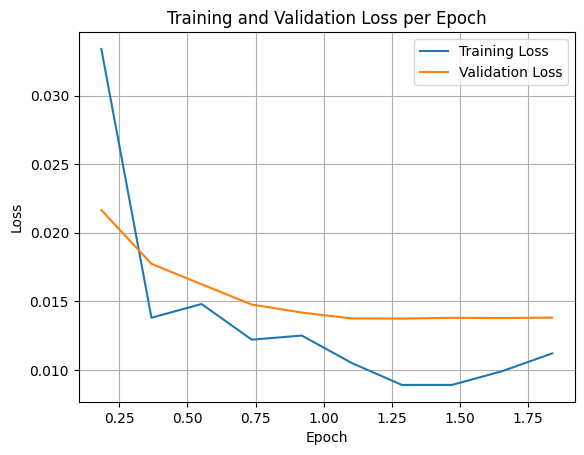

In [13]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

### Test the fine-tuned model

Let's compare your fine-tuned model performance against the base model! Test a few inputs by updating `user_prompt`.

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Create Transformers inference pipeline
trained_model = AutoModelForCausalLM.from_pretrained(output_dir, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(output_dir)
pipe = pipeline("text-generation", model=trained_model, tokenizer=tokenizer)
pipe_base = pipeline("text-generation", model=gemma_model, device_map="auto")

# Test a prompt
user_prompt = "Schedule a \"team meeting\" tomorrow at 4pm."  #@param {type:"string"}
messages = [
    {"role": "developer", "content": "Current date and time given in YYYY-MM-DDTHH:MM:SS format: 2024-11-15T05:59:00. You are a model that can do function calling with the following functions"},
    {"role": "user", "content": user_prompt}
]

# Reuse the tools from the sample
tools = json.loads(dataset[0]['text'])['tools']

prompt = tokenizer.apply_chat_template(
    messages,
    tools=tools,
    tokenize=False,
    add_generation_prompt=True)

print(f"\n\033[1mPrompt:\033[0m {prompt}")
output = pipe(prompt, max_new_tokens=max_token_count)
output_base = pipe_base(prompt, max_new_tokens=max_token_count)
model_output = output[0]['generated_text'][len(prompt):].strip()
model_output_base = output_base[0]['generated_text'][len(prompt):].strip()

print(f"\n\033[1mFine-tuned model output:\033[0m {model_output}")

print(f"\n\033[1mBase model output:\033[0m       {model_output_base}")

Device set to use cuda:0
Device set to use cuda:0



Prompt: <bos><start_of_turn>developer
Current date and time given in YYYY-MM-DDTHH:MM:SS format: 2024-11-15T05:59:00. You are a model that can do function calling with the following functions<start_function_declaration>declaration:send_email{description:<escape>Sends an email.<escape>,parameters:{properties:{body:{description:<escape>The body of the email.<escape>,type:<escape>STRING<escape>},subject:{description:<escape>The subject of the email.<escape>,type:<escape>STRING<escape>},to:{description:<escape>The email address of the recipient.<escape>,type:<escape>STRING<escape>}},required:[<escape>to<escape>,<escape>subject<escape>],type:<escape>OBJECT<escape>}}<end_function_declaration><start_function_declaration>declaration:turn_off_flashlight{description:<escape>Turns the flashlight off.<escape>,parameters:{type:<escape>OBJECT<escape>}}<end_function_declaration><start_function_declaration>declaration:turn_on_flashlight{description:<escape>Turns the flashlight on.<escape>,parameters:

### Evaluate the fine-tuned model

Evaluating a fine-tuned model is essential to ensure that the process actually improved the model's performance without introducing new issues.

In [15]:
#@title Helper functions for evaluation

import pandas as pd

def extract_function_call(model_output):
    """
    Parses a string containing specific function call markers and returns
    a list of function call objects. Here is an example of the obejct:

    ```
    <start_function_call>call:open_map{query:<escape>San Francisco<escape>}<end_function_call>
    ```

    Args:
        model_output (str): The model output string.

    Returns:
        list: A list of dictionaries representing the function calls.
    """
    results = []

    # Pattern to extract the full content of a single function call
    # Flags: DOTALL allows matching across newlines if necessary
    call_pattern = r"<start_function_call>(.*?)<end_function_call>"
    raw_calls = re.findall(call_pattern, model_output, re.DOTALL)

    for raw_call in raw_calls:
        # Check if the content starts with 'call:'
        if not raw_call.strip().startswith("call:"):
            continue

        # Extract function name
        # Expected format: call:func_name{...}
        try:
            # Split only on the first brace to separate name and args
            pre_brace, args_segment = raw_call.split("{", 1)

            function_name = pre_brace.replace("call:", "").strip()

            # Remove the trailing closing brace '}'
            args_content = args_segment.strip()
            if args_content.endswith("}"):
                args_content = args_content[:-1]

            arguments = {}

            # Pattern to extract arguments
            # Looks for: key:<escape>value<escape>
            # The key pattern [^:,]* ensures we don't accidentally eat previous commas
            arg_pattern = r"(?P<key>[^:,]*?):<escape>(?P<value>.*?)<escape>"

            arg_matches = re.finditer(arg_pattern, args_content, re.DOTALL)

            for match in arg_matches:
                key = match.group("key").strip()
                value = match.group("value")
                arguments[key] = value

            results.append({
                "function": {
                    "name": function_name,
                    "arguments": arguments
                }
            })

        except ValueError:
            # Handles cases where syntax might be malformed (e.g., missing '{')
            continue

    return results

def extract_text(model_output):
    """
    Extracts text content and removing the <end_of_turn> marker.

    Args:
        model_output (str): The model output string.

    Returns:
        str: The cleaned text.
    """
    if not model_output or model_output.startswith("<start_function_call>"):
        return None
    return model_output.replace("<end_of_turn>", "").strip()

from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

def get_eval_logs(dataset, pipe):
  batch_size = 1
  logs = []
  # Select a random sample from the test dataset
  for i, output in enumerate(pipe(KeyDataset(dataset, "prompt"), batch_size=batch_size)):
    orig_data = dataset[i]['text']
    messages = json.loads(orig_data)['messages']
    user_message = messages[1]
    assistant_first_message = messages[2]
    input_prompt = dataset[i]['prompt']
    # Generate the output
    model_output_only = output[0]['generated_text'][len(input_prompt):].strip()

    logs.append(
        {
            # The original user prompt/query.
            "user": user_message['content'],

            # List of ground truth function call objects.
            "target_fc": assistant_first_message.get('tool_calls', []),

            # Ground truth text response.
            "target_text": assistant_first_message.get('content'),

            # List of model-generated function call objects.
            "output_fc": extract_function_call(model_output_only),

            # Model-generated text response.
            "output_text": extract_text(model_output_only),
        }
    )

    if (i + 1) % batch_size == 0:
      print(f"Eval process: {(i + 1) * 100.0 / len(dataset):.2f}%")
  return logs

def get_scored_data_frame(dataset, pipe):
  logs = get_eval_logs(dataset, pipe)
  logs_df = pd.DataFrame.from_records(logs)

  scored = pd.DataFrame()
  scored['user'] = logs_df['user']
  scored['target_names'] = logs_df['target_fc'].apply(lambda x: [fc['function']['name'] for fc in x])
  scored['output_names'] = logs_df['output_fc'].apply(lambda x: [fc['function']['name'] for fc in x])
  scored["target_arguments"] = logs_df['target_fc'].apply(lambda x: [dict(sorted(fc['function']['arguments'].items())) for fc in x])
  scored["output_arguments"] = logs_df['output_fc'].apply(lambda x: [dict(sorted(fc['function']['arguments'].items())) for fc in x])
  scored['target_text'] = logs_df['target_text']
  scored['output_text'] = logs_df['output_text']
  scored["correct_names"] = scored["target_names"] == scored["output_names"]
  scored["correct_arguments"] = scored["target_arguments"] == scored["output_arguments"]
  scored["correct"] = scored["correct_names"] & scored["correct_arguments"]

  return scored

def review(scored):
  scored["incorrect_names"] = scored["target_names"] != scored["output_names"]
  scored["incorrect_arguments"] = scored["target_arguments"] != scored["output_arguments"]
  scored["incorrect"] = scored["incorrect_names"] | scored["incorrect_arguments"]

  for index, row in scored[scored["incorrect"]].iterrows():
    print(f"\033[1mSample #{index} prompt  \033[0m: {row["user"]}")
    print(f"\033[1mSample #{index} expected\033[0m: {row["target_names"]}, {row["target_arguments"]}")
    print(f"\033[1mSample #{index} actual  \033[0m: {row["output_names"]}, {row["output_arguments"]}")
    print("---------------")


In [16]:
#@title Evaluate the base model

base_scored = get_scored_data_frame(
    eval_dataset,
    pipeline("text-generation", model=gemma_model, device_map="auto", temperature = 0.001),
)

base_scored

Device set to use cuda:0


Eval process: 0.10%
Eval process: 0.21%
Eval process: 0.31%
Eval process: 0.42%
Eval process: 0.52%
Eval process: 0.62%
Eval process: 0.73%
Eval process: 0.83%
Eval process: 0.94%
Eval process: 1.04%
Eval process: 1.14%
Eval process: 1.25%
Eval process: 1.35%
Eval process: 1.46%
Eval process: 1.56%
Eval process: 1.66%
Eval process: 1.77%
Eval process: 1.87%
Eval process: 1.98%
Eval process: 2.08%
Eval process: 2.19%
Eval process: 2.29%
Eval process: 2.39%
Eval process: 2.50%
Eval process: 2.60%
Eval process: 2.71%
Eval process: 2.81%
Eval process: 2.91%
Eval process: 3.02%
Eval process: 3.12%
Eval process: 3.23%
Eval process: 3.33%
Eval process: 3.43%
Eval process: 3.54%
Eval process: 3.64%
Eval process: 3.75%
Eval process: 3.85%
Eval process: 3.95%
Eval process: 4.06%
Eval process: 4.16%
Eval process: 4.27%
Eval process: 4.37%
Eval process: 4.47%
Eval process: 4.58%
Eval process: 4.68%
Eval process: 4.79%
Eval process: 4.89%
Eval process: 4.99%
Eval process: 5.10%
Eval process: 5.20%


,user,target_names,output_names,target_arguments,output_arguments,target_text,output_text,correct_names,correct_arguments,correct
0,I need to connect to a new Wi-Fi network right...,[open_wifi_settings],[open_wifi_settings],[{}],[{}],None,None,True,True,True
1,Please turn off my flashlight and schedule a c...,"[turn_off_flashlight, create_calendar_event]","[turn_off_flashlight, create_calendar_event]","[{}, {'datetime': '2024-05-13T09:30:00', 'titl...","[{}, {'datetime': '2024-05-13T09:30:00', 'titl...",None,None,True,True,True
2,Can you set up a calendar event for a video ca...,[create_calendar_event],[create_calendar_event],"[{'datetime': '2026-04-21T19:30:00', 'title': ...","[{'datetime': '2026-04-21T19:30:00', 'title': ...",None,None,True,False,False
3,Turn off the flashlight and send an email righ...,"[turn_off_flashlight, send_email]","[turn_off_flashlight, send_email]","[{}, {'body': 'I need to move our 2 PM call to...","[{}, {'body': 'I need to move our 2 PM call to...",None,None,True,True,True
4,Schedule a calendar event called 'Call with in...,[create_calendar_event],[create_calendar_event],"[{'datetime': '2026-09-03T14:00:00', 'title': ...","[{'datetime': '2026-09-08T14:00:00', 'title': ...",None,None,True,False,False
...,...,...,...,...,...,...,...,...,...,...
956,Please schedule a calendar event titled 'Check...,"[create_calendar_event, show_map]","[create_calendar_event, show_map]","[{'datetime': '2025-05-02T10:00:00', 'title': ...","[{'datetime': '2025-05-02T10:00:00', 'title': ...",None,None,True,False,False
957,Can you send an email to adriana.silva@webmail...,[send_email],[send_email],"[{'body': 'Hey Adriana, sorry but I have to re...","[{'body': 'Hey Adriana, sorry but I have to re...",None,None,True,True,True
958,"Please schedule a calendar event called ""Revie...","[create_calendar_event, send_email]","[create_calendar_event, send_email]","[{'datetime': '2025-09-03T14:00:00', 'title': ...","[{'datetime': '2025-09-03T14:00:00', 'title': ...",None,None,True,True,True
959,Please send an email to aaliyah.khan.pm@rental...,[send_email],[send_email],[{'body': 'The dishwasher stopped working last...,[{'body': 'The dishwasher stopped working last...,None,None,True,True,True


In [17]:
#@title Evaluate the fine-tuned model

from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
trained_model = AutoModelForCausalLM.from_pretrained(output_dir, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(output_dir)

trained_scored = get_scored_data_frame(
    eval_dataset,
    pipeline("text-generation", model=trained_model, tokenizer=tokenizer, temperature = 0.001)
)

trained_scored

Device set to use cuda:0


Eval process: 0.10%
Eval process: 0.21%
Eval process: 0.31%
Eval process: 0.42%
Eval process: 0.52%
Eval process: 0.62%
Eval process: 0.73%
Eval process: 0.83%
Eval process: 0.94%
Eval process: 1.04%
Eval process: 1.14%
Eval process: 1.25%
Eval process: 1.35%
Eval process: 1.46%
Eval process: 1.56%
Eval process: 1.66%
Eval process: 1.77%
Eval process: 1.87%
Eval process: 1.98%
Eval process: 2.08%
Eval process: 2.19%
Eval process: 2.29%
Eval process: 2.39%
Eval process: 2.50%
Eval process: 2.60%
Eval process: 2.71%
Eval process: 2.81%
Eval process: 2.91%
Eval process: 3.02%
Eval process: 3.12%
Eval process: 3.23%
Eval process: 3.33%
Eval process: 3.43%
Eval process: 3.54%
Eval process: 3.64%
Eval process: 3.75%
Eval process: 3.85%
Eval process: 3.95%
Eval process: 4.06%
Eval process: 4.16%
Eval process: 4.27%
Eval process: 4.37%
Eval process: 4.47%
Eval process: 4.58%
Eval process: 4.68%
Eval process: 4.79%
Eval process: 4.89%
Eval process: 4.99%
Eval process: 5.10%
Eval process: 5.20%


,user,target_names,output_names,target_arguments,output_arguments,target_text,output_text,correct_names,correct_arguments,correct
0,I need to connect to a new Wi-Fi network right...,[open_wifi_settings],[open_wifi_settings],[{}],[{}],None,None,True,True,True
1,Please turn off my flashlight and schedule a c...,"[turn_off_flashlight, create_calendar_event]","[turn_off_flashlight, create_calendar_event]","[{}, {'datetime': '2024-05-13T09:30:00', 'titl...","[{}, {'datetime': '2024-05-13T09:30:00', 'titl...",None,None,True,True,True
2,Can you set up a calendar event for a video ca...,[create_calendar_event],[create_calendar_event],"[{'datetime': '2026-04-21T19:30:00', 'title': ...","[{'datetime': '2026-04-21T19:30:00', 'title': ...",None,None,True,False,False
3,Turn off the flashlight and send an email righ...,"[turn_off_flashlight, send_email]","[turn_off_flashlight, send_email]","[{}, {'body': 'I need to move our 2 PM call to...","[{}, {'body': 'I need to move our 2 PM call to...",None,None,True,True,True
4,Schedule a calendar event called 'Call with in...,[create_calendar_event],[create_calendar_event],"[{'datetime': '2026-09-03T14:00:00', 'title': ...","[{'datetime': '2026-09-04T14:00:00', 'title': ...",None,None,True,False,False
...,...,...,...,...,...,...,...,...,...,...
956,Please schedule a calendar event titled 'Check...,"[create_calendar_event, show_map]","[create_calendar_event, show_map]","[{'datetime': '2025-05-02T10:00:00', 'title': ...","[{'datetime': '2025-05-02T10:00:00', 'title': ...",None,None,True,True,True
957,Can you send an email to adriana.silva@webmail...,[send_email],[send_email],"[{'body': 'Hey Adriana, sorry but I have to re...","[{'body': 'Hey Adriana, sorry but I have to re...",None,None,True,True,True
958,"Please schedule a calendar event called ""Revie...","[create_calendar_event, send_email]","[create_calendar_event, send_email]","[{'datetime': '2025-09-03T14:00:00', 'title': ...","[{'datetime': '2025-09-03T14:00:00', 'title': ...",None,None,True,True,True
959,Please send an email to aaliyah.khan.pm@rental...,[send_email],[send_email],[{'body': 'The dishwasher stopped working last...,[{'body': 'The dishwasher stopped working last...,None,None,True,True,True


In [18]:
#@title Compare the score of the base and fine-tuned models

# Optional: save the score in json file
trained_scored.to_json('scored_df_20251215_trained.json')
base_scored.to_json('scored_df_20251215_base.json')

print(f"\033[1mBase model score\033[0m       : {base_scored["correct"].mean()}")
print(f"\033[1mFine-tuned model score\033[0m : {trained_scored["correct"].mean()}")

Base model score       : 0.5796045785639958
Fine-tuned model score : 0.8428720083246618


## Review what are not matching

The score about tell how much eval data get exactly correct function calls. It gives the lower bound of correctness. Some output might not match the eval date but still acceptable. For example, the `show_map` function call below:

* show_map:{'query': 'Maison Marulaz, Besançon, France'}
* show_map:{'query': 'Maison Marulaz in Besançon, France'}

Let's take a look at the eval date without exact match. Many of them could also be acceptable.

In [19]:
review(trained_scored)

Sample #2 prompt  : Can you set up a calendar event for a video call with Grandma Elena? It needs to be scheduled for 7:30 PM on Tuesday, April 21st, 2026.
Sample #2 expected: ['create_calendar_event'], [{'datetime': '2026-04-21T19:30:00', 'title': 'video call with Grandma Elena'}]
Sample #2 actual  : ['create_calendar_event'], [{'datetime': '2026-04-21T19:30:00', 'title': 'Video call with Grandma Elena'}]
---------------
Sample #4 prompt  : Schedule a calendar event called 'Call with insurance agent Sofia Rossi' for this coming Thursday at 2 PM.
Sample #4 expected: ['create_calendar_event'], [{'datetime': '2026-09-03T14:00:00', 'title': 'Call with insurance agent Sofia Rossi'}]
Sample #4 actual  : ['create_calendar_event'], [{'datetime': '2026-09-04T14:00:00', 'title': 'Call with insurance agent Sofia Rossi'}]
---------------
Sample #8 prompt  : Can you please turn off the flashlight and also create a calendar event titled "Client Follow-up" for Thursday at 4:00 PM?
Sample #8 expected

Does the model call the function you'd expect?

If you're not getting the results you want, you can try [using different hyperparameters](#scrollTo=-BJFoOdL0y8w) to train the model, or updating your training dataset to contain more representative examples.

Once you're happy with the results, you can save your model to Hugging Face Hub.

## Save your model and upload to Hugging Face Hub
**You now have a customized FunctionGemma 270M model! 🎉**

Upload it to a repository on Hugging Face Hub so you easily share your model or access it later.

In [20]:
from huggingface_hub import ModelCard, ModelCardData, whoami

trained_model = AutoModelForCausalLM.from_pretrained(output_dir, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(output_dir)

#@markdown Name your model
model_name = "mobile-actions"    #@param {type:"string"}

username = whoami()['name']
hf_repo_id = f"{username}/functiongemma-270m-it-{model_name}"

repo_url = trained_model.push_to_hub(hf_repo_id, create_repo=True, commit_message="Upload model")
tokenizer.push_to_hub(hf_repo_id)

card_content = f"""
---
base_model: {gemma_model}
tags:
- function-calling
- mobile-actions
- gemma
---
A fine-tuned model based on `{gemma_model}`."""
card = ModelCard(card_content)

card.push_to_hub(hf_repo_id)

print(f"Uploaded to {repo_url}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...78wxx72/model.safetensors:   0%|          | 1.17MB / 1.07GB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ptb0uym77/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mptb0uym77/tokenizer.json:  25%|##4       | 8.28MB / 33.4MB            

Uploaded to https://huggingface.co/binaryrm/functiongemma-270m-it-mobile-actions/commit/5e10c8b1b7bc843125f2101e2bc528e8dff2cf7e


## Conversion to .litertlm for on-device deployment

The first step is to install the necessary libraries using the `pip` package installer.

In [ ]:
!pip uninstall -y tensorflow
!pip install ai-edge-torch-nightly --force-reinstall
!pip install ai-edge-litert-nightly

  Using cached ai_edge_torch_nightly-0.8.0.dev20260105-py3-none-any.whl.metadata (2.4 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached numpy-2.4.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached multipledispatch-1.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached tf_nightly-2.21.0.dev20260105-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (4.5 kB)
  Using cached ai_edge_litert_nightly-2.2.0.dev20260104-cp312-cp312-manyli

### Build the .litertlm from the fine-tuned model

After running the script below, you can find the converted model in located in `/content/litertlm/mobile-actions_q8_ekv1024.litertlm` in the colab environment. Copy it to a persistent storage like Google Drive.

In [24]:
import os
from ai_edge_torch.generative.examples.gemma3 import gemma3
from ai_edge_torch.generative.utilities import converter
from ai_edge_torch.generative.utilities.export_config import ExportConfig
from ai_edge_torch.generative.layers import kv_cache

# Metadata for FunctionGemma
llm_metadata = r"""start_token: {
    token_ids: {
        ids: [ 2 ]
    }
}
stop_tokens: {
    token_str: "<end_of_turn>"
}
stop_tokens: {
    token_str: "<start_function_response>"
}
llm_model_type: {
    function_gemma: {}
}
"""

checkpoint_dir = "/content/mobile-actions-functiongemma"

litertlm_output_dir = '/content/litertlm'
os.makedirs(litertlm_output_dir, exist_ok=True)

# Create the LLM metadata file
metadata_path = os.path.join(litertlm_output_dir, 'base_llm_metadata.textproto')
with open(metadata_path, 'w') as f:
  f.write(llm_metadata)

# Import the weights and build the PyTorch model
pytorch_model = gemma3.build_model_270m(checkpoint_dir)

# Setup the export configurations and parameters for text generation models.
export_config = ExportConfig()
export_config.kvcache_layout = kv_cache.KV_LAYOUT_TRANSPOSED
export_config.mask_as_input = True

# Convert to LiteRT-LM Format
converter.convert_to_litert(
    pytorch_model,
    output_path=litertlm_output_dir,
    output_name_prefix="mobile-actions",
    prefill_seq_len=256,
    kv_cache_max_len=1024,
    quantize="dynamic_int8",
    export_config=export_config,
    tokenizer_model_path=os.path.join(checkpoint_dir, 'tokenizer.model'),
    base_llm_metadata_path=metadata_path,
    output_format="litertlm",
)


RuntimeError: Dialect namespace 'tt' is already registered.

### Save the `.litertlm` on Google Drive

To deploy the converted model on [Google AI Edge Gallery](https://play.google.com/store/apps/details?id=com.google.ai.edge.gallery), we can first store the model on Google Drive. On the Gallery app, import the model from Google Drive later.

In [ ]:
#@title Mounting Google Drive on the colab environment

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Save the `.litertlm` on Google Drive

!mkdir -p /content/drive/MyDrive/mobile-actions/
!cp /content/litertlm/mobile-actions_q8_ekv1024.litertlm /content/drive/MyDrive/mobile-actions/

## Summary and next steps

Congratulations! You have completed the first part of [Fine-tune FunctionGemma 270M for Mobile Actions](https://ai.google.dev/gemma/docs/mobile-actions).

You have successfully finetuned the FunctionGemma 270M with the Mobile Actions dataset and converted it to `.litertlm` format.